### Report 

author: Antonin Hruska (hruskan1@fel.cvut.cz / antonin.hruska.96@gmail.com)

This is a report for interview assinment for Datamole assigned on 08/03/24.

#### Initial setup and fast brainstorming 
080324 1310-1336 26 min

 - Download of repo and setup of enviroment and creating own git repo (local and remote)
 - Looking at .parquet file format (no experience before): https://inside-machinelearning.com/en/open-parquet-python/
 - Setup of miniconda env
 Summary: go with pandas 

 First look at the data
 
 Brainstorming:
 - task is to do *fault detection* from equidistant time series (detectiong the PumpFailed flag)
    - similar to lecture 11/12 in OFD course (https://intranet.fel.cvut.cz/cz/education/bk/predmety/46/79/p4679606)
        - likelihood tests 
    - trivial approach / baseline (given the description in readme) -> compute running (window) average or EWA or median and use it as a predictor (assume there is no dynamics in the system) and compare the difference (use threshold and ROC to tune it)
 


#### Further brainstorming
170324 1839-2114 (Partially done in background during military exercise) 145 + 60 = 205 min 
(Counting only 60 min, since I reasoned on incorrect assumptions)

**THIS BRAINSTORMING IS INVALID SINCE I MISUNDERSTOOD THE TYPE OF THE DATA** (190324 0011)

Assuming we have data(set) of timeseries:
$$
\mathcal{D}_{\mathcal{T}} = \{(\boldsymbol{y}_i^j,\boldsymbol{s}_i^j) | i \in \{1,\dots,\text{\# machines}\}, j \in \{1,\dots,\text{\# cycles}_i\}\}
$$
where $\boldsymbol{y}_i^j \in \mathbb{R}^{n_i^j}$ corresponds to presure measurment for $i$ th machine and $j$ th measure cycle
of length $n_i^j$ (different for each measure cycle and machine)
and $ \boldsymbol{s}_i^j \in \{0,1\}^{n_i^j} $ corresponding to the flag PumpFailed.

The likelihood tests are based on hypothesis testing, where the 
 -  Null hypothesis (H0) is that the system runs flawlessly.
 -  Alternative hypothesis (H1) is that the system is experiencing faults or anomalies.
Likelihood ratio then express the relative likelihood of observed data under different hypotheses. We can use the threshold 
to detect the fault (use Reciever Operating Curve to tune it up).
To be able to use this framework, we need to create the model (for both hypothesis) and filter the time series:
$$
p_{0}(x_{t} | y_{1:t}), p_{1}(x_{t} | y_{1:t})
$$
where $x_{t}$ is a vector of (partially) hidden variables and depends on model. One can assume that the $s_t$ is a part of the vector. We then compare the ratio with threshold $\theta$:
$$
\log(\frac{p_{1}}{p_{0}}) = \log p_{1} - \log p_{0} \leq \theta
$$
to filter the value $s_t$.


The question is the good choice of the model $p_0$ and $p_1$. We can exploit our knowledge and assumptions in selecting process. We have several options with different complexity and different level of implicit regularization, both will have effect on *quality* (stronger regularization is needed in lack of *good* data). 

We can exploit the fact that we are modelling the physical system and try to obtain the physical system -> Get the background knowledge of the used Air Pump and built its state space model, discretize it and use Kalman Filter or its alternatives in case of nonlinearity, or go with Particle Filter. The issue is with modelling of the failed state, as there is no good understanding of what is the cause of the failure and how to model it. This can be partially solved by obtaining more information from the customer. 

Next option is to use AR (ARX) or ARMA (ARMAX) input output model with fixed order to obtain the dynamic system from the measurements. This would save us from the modelling of the physics of the air pump, but we would still need the input to the system in order to apply it. (The system is obviously not autonomus.)   

Another possibility is to drop the information about the dynamics of the model altogether. In that case, one could think about
using a homogenous Hidden Markov chain to model the $s_t$ while assuming the $p(s_t|y_t)$ is a gaussian or mixture of gaussian (using EM, or iterative gradient descent to learn it). We could also compute the features from the $y$, such as first and second difference (coming back to the dynamics of the model).

To simplify the model even further, we could drop the information about the continuity and regard the instance as a binary classification problem,comparing only $p_0(s_t|y_t)$ and $p_1(s_t|y_t)$.

As far as the deep learning is concerned, one could use RNN/LSTM to mimic the state AR, that means in regression setting and then applying the threshold on the difference between measured and predicted. The network would be trained only on true positives, all others would be outliers. But RNN or LSTM are data hungry models and could easily overfit the data. 

Another option is to construct the simple MLP with fixed time window and predict the next measurment (regression), or drop the continuity and treat it as a classification problem as mentioned above. 

One could also use other techinque for the binary classification, such as SVM, Random Forest.

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.compute as pc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data inspection and vizualization
180324 2330-0211 161 min

In [80]:
# Partially generated by ChatGPT
data_path = './data.parquet'
labels_path = './labels.csv'
# Read the .parquet file into a pandas DataFrame
df = pd.read_parquet(data_path)
lf = pd.read_csv(labels_path)
padf = pa.parquet.read_table(data_path)

# Display the first few rows of the DataFrame to understand and verify the datastructure
# print(df.head())
# print(lf.head())

# Drop invalid values
df = df[(df['MeasurementId'] != -1) & (df['MeasurementId'].notna())]
lf = lf[(lf['MeasurementId'] != -1) & (lf['MeasurementId'].notna())]
padf = padf.filter((pc.field('MeasurementId') != pc.scalar(-1)) & (~pc.field('MeasurementId').is_nan()))
assert df.notna().all().all()
assert lf['MeasurementId'].notna().all().all()
assert lf['MachineId'].notna().all().all()

print(f'{df.shape=},{lf.shape=}')
print(df.head())
print(lf.head())
print(padf.shape)
print(type(padf['Pressure']))

df.shape=(13195033, 3),lf.shape=(26900, 5)
  MachineId  MeasurementId  Pressure
0     0_0_0              0       0.0
1     0_0_0              0       0.0
2     0_0_0              0       0.0
3     0_0_0              0       0.0
4     0_0_0              0       0.0
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0     0_0_0              0      False     False   False
2     0_0_2              0      False     False   False
3     0_0_3              0       True     False   False
5     0_1_1              1       True     False   False
8     1_0_0              2      False      True   False
(13195033, 3)
<class 'pyarrow.lib.ChunkedArray'>


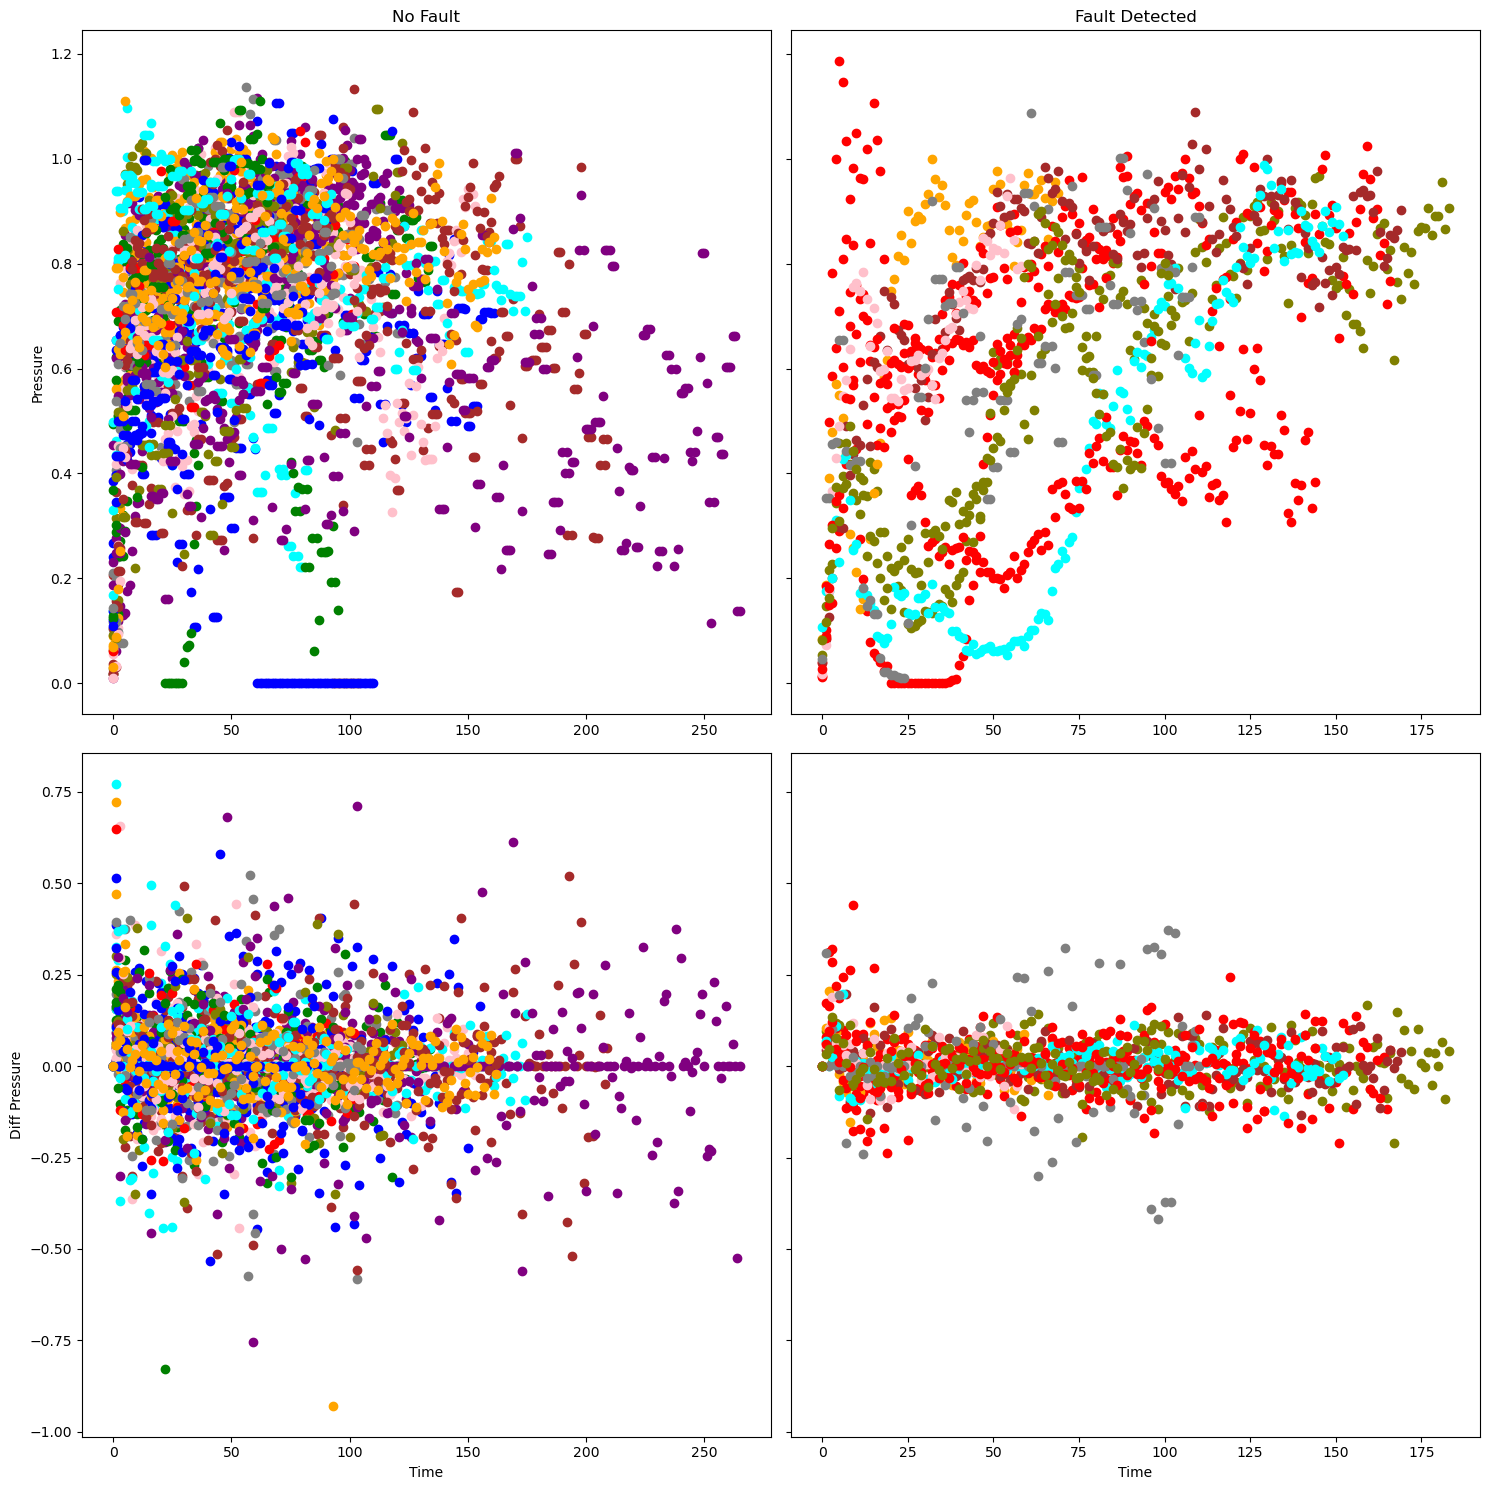

In [268]:
# Create a new figure and subplot
number_of_runs_to_show = 50
randomize = True # bool
specific_machine = None # [None,'x_y_z']
only_faulty = False
slow_start = False # None or bool if None, both are possible
slow_end = None # None or bool
scaling_qutionet = 0.99  #[None of float] scale by value at given quantile
trimm_eps = 0.01 # [None or float]
take_only_first_half = True
ewa = None #ewa coefficients [None or float]

fig, axs = plt.subplots(2, 2, figsize=(15, 15),sharey='row')
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


if randomize:
    ilf =lf.sample(frac=1)
else:
    ilf = lf
if specific_machine is not None:
    ilf = ilf[ilf['MachineId'] == specific_machine]
if only_faulty:
    ilf = ilf[ilf['PumpFailed'] == True]
if slow_start is not None:
    ilf = ilf[ilf['SlowStart'] == slow_start]
if slow_end is not None:
    ilf = ilf[ilf['SlowEnd'] == slow_end]
    
# Iterate through rows of lf DataFrame
for index, (_, row) in enumerate(ilf.iterrows()):
    label = row['PumpFailed']
    machine_id = row['MachineId']
    measurement_id = row['MeasurementId']
    
    # Retrieve the time series data from df DataFrame
    pressure = utils.get_presure_serie_for_machine_and_measurement(df,machine_id,measurement_id)
    
    # Scale
    if scaling_qutionet:
        _i = min(int(scaling_qutionet * len(pressure)),len(pressure)-1)
        scaling_factor = pressure.sort_values(ascending=True).iloc[_i]
        pressure = pressure / scaling_factor# Only positive values starting from 0
    
    # Trim   
    if trimm_eps is not None:
        pressure = utils.trim_series(pressure,eps=trimm_eps)

    # Cut
    if take_only_first_half:
        pressure = pressure.iloc[:int(len(pressure) // 2)]
    
    # Ewa
    if ewa:
        ewa_pressure = utils.exponential_weighted_average(pressure.values,alpha=ewa)
    pressure_diff = np.insert(np.diff(pressure.values),0,0)
    
    
    
    # Plot the time series in the appropriate subplot based on the label
    c = colors[index%len(colors)]
    if label == 0:  
        pressure_ax = axs[0,0]
        pressure_diff_ax = axs[1,0]
        pressure_ax.set_title('No Fault')
    else:
        pressure_ax = axs[0,1]
        pressure_diff_ax = axs[1,1]
        pressure_ax.set_title('Fault Detected')
    
    if ewa:
        pressure_ax.scatter(np.arange(len(pressure)), pressure.values, label=f'Mach.: {machine_id}, Meas.: {measurement_id}',linestyle='--',color='black',alpha=0.5)
        pressure_ax.scatter(np.arange(len(ewa_pressure)), ewa_pressure, label=f'Mach.: {machine_id}, Meas.: {measurement_id} ewa',color=c,alpha=1)
    else:
        pressure_ax.scatter(np.arange(len(pressure)), pressure.values, label=f'Mach.: {machine_id}, Meas.: {measurement_id}',color=c)
    pressure_diff_ax.scatter(np.arange(len(pressure)), pressure_diff, label=f'Mach.: {machine_id}, Meas.: {measurement_id}',color=c)
        
    if index > number_of_runs_to_show:
        break

# Add legend and labels to the subplots


axs[1,0].set_xlabel('Time')
axs[0,0].set_ylabel('Pressure')
axs[1,0].set_ylabel('Diff Pressure')
axs[1,1].set_xlabel('Time')
if number_of_runs_to_show < 10:
    axs[0,0].legend()
    axs[0,1].legend()
# Show the plot
plt.tight_layout()
plt.show()

After visualization of few runs and reading the description of the fault, I opt to minmax rescale each time series and add EWA computation. 

I also add the diff of the pressure to se the changes (the second difference could be even more telling) and other flags for easier visualization. 

The following was done later (after brainstroming #2):
After another examination, I did a robust version selecting the scaling factor by given quotient, I trimmed the time series and added a flag to plot only the first half of the cycle (see the documentation)
After another examination, I added the flag to optionaly select slow start and slow end.

In [141]:
print(f"Number of experiments:{len(lf)}, fault ratio: {len(lf[lf['PumpFailed']])/len(lf):2.4f}")

Number of experiments:26900, fault ratio: 0.1094


#### Brainstorming #2

190324 0636 - 0715, 0911-1058 39 + 107 = 146 min

##### Metrics and evaluation
TODO: ASK ABOUT *predictivness* of the model. (SOVLED)
If the model can run in offline mode (produce result after the run), the metrics and evaluation procedures are quite straightforward. We can simply use accuracy/confusion matrix.
If the model should !predict! the fault in any given time, then we can also measure time of detection of our model. 

With regards to training/validation methodology. We have quite inbalanced set and random (fixed ratio) split could produce high variance in our result and weaker results and thus more iteration to obtain statistically significant results. We could use k-fold cross validation and stratify the folds. For the time being, we will do simple train,val, (test) split. 

##### Models
Due to the imbalance in our training set, we can use a prior and compare the joint probabilities instead of conditional. This is however already accounted in using the threshold (which can be tuned through ROC curve). 

Lets start with the model for non faulty state $p_{\theta}(x|s=0)$ using a simple Naive Bayes model.From the describtion, we are anticipating almost a rectangular signal (up to the SlowStart and SlowEnd), in this case, lets assume that the signal is stationary around 100%, lets assume white gaussian noise with fixed sigma and obtain ML estimate, i.e. our model is:
$$
p_{\mu}(x|s=0) = \prod_{i=1}^{m} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) = L(\mu | x_1, x_2, ..., x_n) \to \max_{\mu}\\
$$
$$
l(\mu | x) = \log L(\mu | x_1, x_2, ..., x_m) \\
= \sum_{i=1}^{m} \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) \right) \\
= -\frac{n}{2} \log(2\pi\sigma^2) - \sum_{i=1}^{m} \frac{(x_i - \mu)^2}{2\sigma^2}\\
\frac{\partial l}{\partial \mu} \stackrel{!}= 0 \implies \mu = \frac{1}{m}\sum_{1}^m x_i
$$
The minmax scaling allow us to use this model across multiple cycles and machine, but further feature improvment in robustness is recommended. 
The learning is simple, we will estimate the $\mu$ across all cycles and machine in training data. During inference,we will compute the probability of the data under learned model. 

In case of $p_{\theta}(x|s=1)$, we want to model the situation where the fault manifests itselfs. To start with, assume that the hidden varible $h_i \in \{0,1\}$ denotes that at time i the fault has occured and the pump is not able to work at the required set point. The most simplistic assumption is to disregard the dynamics of the system and pump just the jumps to the other (lower) set point where it is sationary. Disregarding the assumption on continuity of this fault, we can model the sitatuation as a mixture of two gaussians,where $\pi = p(h_i = 1)$ determins from which gaussian the data came from, i.e.
$$
p_{\theta}(x| s=1) = \sum_{h} p_{\theta}(x,h | s=1) = \prod_{i=1}^{m} \frac{1}{\sqrt{2\pi\sigma^2}} \left(\pi \exp\big(-\frac{(x_i - \mu_1)^2}{2\sigma^2}\big) +  (1-\pi)  \exp\big(-\frac{(x_i - \mu_0)^2}{2\sigma^2}\big)  \right)
$$ 
where $\theta = \{\pi,\mu_0,\mu_1\}$.

We can use the EM algorithm to maximize the $p_{\theta}(x| s=1)$ for a given data (i.e. for learning). We initilize the model ($\mu_0 \approx 1, \mu_1 \approx 0, \pi \approx 0.1$)

In the E step, we compute the $\alpha_{i}^{t}(h) = p_{\theta^{t}}(h|x_i) = \frac{p_{\theta^{t}}(h,x)}{p_{\theta^{t}}(x)}$

In the M step, we try to maximize the Evidence lower bound of $p_{\theta}(x| s=1)$, this leads to 

$$
\mu_k = \frac{\sum_{i = 1}^m \alpha_{i}^{t}(h = k) x_i}{\sum_{1}^m \alpha_{i}^{t}(h = k)}  = \frac{1}{N_k} \sum_{i = 1}^m \alpha_{i}^{t}(h = k) x_i \\
\pi = \frac{N_1}{m}
$$
where $N_k = \sum_{i = 1}^m \alpha_{i}^{t}(h = k)$

We iterate the algorithm until the convergence, i.e. if the $\theta$ is changing or we stop after given number of iterations.
One could also think about the Markov Hidden chain where we would also model the trainsition probabilities between $h_i$ and $h_{i+1}$. It could be learned also by EM algorithm.

In [16]:
seed = 42
test_ratio = 0.1
val_ratio = 0.2

from sklearn.model_selection import train_test_split


rlf = lf.reset_index(drop=True)


temp_lf, test_lf = train_test_split(rlf, test_size=test_ratio, random_state=seed)
train_lf, val_lf = train_test_split(temp_lf, test_size=val_ratio/(1. - test_ratio), random_state=seed)

# Print the sizes of the splits
print(f"Train data size: {len(train_lf)/len(rlf)} ")
print(f"Validation data size: {len(val_lf)/len(rlf)} ")
print(f"Test data size: {len(test_lf)/len(rlf)} ")


Train data size: 0.7 
Validation data size: 0.2 
Test data size: 0.1 


#### Further analysis before implementation
190324 1612-1749 97 min # HERE  I HIT THE OFFICAL 8 HOURS of WORKING DEADLINE

Before implementing the model, I have returned back to data to have closer look and validate if my model could work. 
I started with simple plotting of all possible available data (with other faults) to see following image:

<img src="./imgs/all_faults_full_length.png" alt="Image" width="1000" height="1000">

First, we need to increase the trim_eps to remove the false starts. Also there is a incorrectly segmented cycle (upper left image, red) I also started to use the scatter to improve visibility. In next image, we can see a slight a visible difference between faulty and nonfaulty data, which occurs mostly at the beginning of the sequence (roughly in first quarter).

<img src="./imgs/more_all_faults_only_half.png" alt="Image" width="1000" height="1000">

After deeper inspection of the data, I am reserved in hopes of a good results. The fault does manifest, but the model is far from data-agnostic and even the very simplistic model, which was put forward might not catch the change in the data.

Simplistic solution, take only first quarter of the trimmed and scaled sequence, zero hypothesis is that it should be working around 100%. ($\mu_0=1$)
Alternative hypothesis is that the pump is working less pressurized -> learn relative fit of $\mu_1$ by square minimization -> compute mean for faulty sequences. compute the log-probability during inference and compare.

$$
\log(\frac{p_\theta(x,s=1)}{p_\theta(x,s=0)}) > 0\\
\log\frac{p_\theta(x|s=1)p(s=1)}{p_\theta(x|s=0)p(s=0)} > 0 \\
\log p_\theta(x|s=1) -\log p_\theta(x|s=0) > \log p(s=0) - \log p(s=1)\\
\sum_{i=1}^{l} \left( -\frac{1}{2} \log(2\pi\sigma^2) - \frac{(x_i - 1)^2}{2\sigma^2} \right) - 
\left( -\frac{1}{2} \log(2\pi\sigma^2) - \frac{(x_i - \mu_1)^2}{2\sigma^2} \right) > \log (\frac{p(s=0)}{p(s=1)}) \\
\sum_{i=1}^{l} \left(\frac{(x_i - \mu_1)^2}{2\sigma^2} - \frac{(x_i - 1)^2}{2\sigma^2} \right) > \log (\frac{p(s=0)}{p(s=1)})\\
\sum_{i=1}^{l} \left((x_i - \mu_1)^2 - (x_i - 1)^2 \right) > 2\sigma^2\log (\frac{p(s=0)}{p(s=1)})
$$
We can either fixed the sigma (say $\sigma=1$ for simplicity), or we can do the ROC curve and tune it on validation data.

More complex models could be built, such as fitting of some base functions through linear regression and then compering the error.


In [64]:
class CustomGaussian():
    def __init__(self):
        pass

    def fit(self, X,prior,fit_variance=False):
        self.prior = prior
        self.mean  = X.mean() 
        self.variance = 1
        if fit_variance:
            self.variance = X.var() 
        return 
    
    def set_params(self,prior,mean,variance):
        self.prior = prior
        self.mean = mean
        self.variance = variance
    
    def predict_proba(self, X):
        exponent = -0.5 * np.sum( ((X - self.mean) ** 2) / self.variance, axis=-1)
        return np.exp(exponent) / np.sqrt(2 * np.pi * self.variance)
    

def process_pressure(pressure):
    """
    Process the pressure pyarray by trimming, cutting, and scaling it.
    
    Parameters:
        pressure (numpy.ndarray): The input pressure array.
        
    Returns:
        numpy.ndarray: The processed pressure array.
    """
    # Trim
    pressure = utils.trim_array(pressure)
    
    # Cut 
    pressure = utils.cut_array(pressure)

        
    # Scale
    pressure = utils.scale_array(pressure)
    
    return pressure


In [ ]:
# EXTREMELY SLOW TO RUN -> TRIED TO USE PYARROW, PARTIAL IMPROVMENT
X_pump_failed = []
X_pump_not_failed = []

for index, (_, row) in enumerate(train_lf.iterrows()):
    label = row['PumpFailed']
    machine_id = row['MachineId']
    measurement_id = row['MeasurementId']
    
    # Retrieve the time series data from df DataFrame 
    # had to use pyarrow, pd to slow but still slow
    pressure =  padf.filter((pc.field('MeasurementId') == measurement_id) & (pc.field('MachineId') == machine_id))['Pressure']
    
    try:
        processed_pressure = process_pressure(pressure)
    except ValueError:
        print(f"{_,machine_id,measurement_id,label} is invalid measurment (all zeros)")
        continue
    if len(processed_pressure) < 10:
        print(f"{_,machine_id,measurement_id,label} might be invalid measurment (short trimmed)")
    if label:
        X_pump_failed.append(processed_pressure)
    else:
        X_pump_not_failed.append(processed_pressure)
    
    print(f"{index}/{len(train_lf)}",end='\r')
    
    if index % 100 == 99 or index == len(val_lf) -1 :
        X_train_pump_failed = pa.concat_arrays(X_pump_failed)  
        X_train_pump_not_failed = pa.concat_arrays(X_pump_not_failed)
        X_pump_failed = [X_train_pump_failed]
        X_pump_not_failed = [X_train_pump_not_failed]
    
X_train_pump_failed = pa.concat_arrays(X_pump_failed)  
X_train_pump_not_failed = pa.concat_arrays(X_pump_not_failed)
print(len(X_train_pump_failed))
print(len(X_train_pump_not_failed))

# plt.tight_layout()
# plt.show()

In [156]:
X_train_pump_not_failed_ = X_train_pump_not_failed.to_numpy()
X_train_pump_failed_ = X_train_pump_failed.to_numpy()

#### Experiments
190324 2012-2315 183 min 
In follwing script, we have run several experiments (on small scale of data -> it was then rewritten to train on all available data)
 
1)  Fixed null hypothesis with fixed variance ($\mu_0 = 1, \sigma_0 = \sigma_1 = \sigma$), only $\mu_1$ learned
2)  Fixed variance, learnable $\mu_0$ and $\mu_1$.
3)  True Naive Bayes Gaussians (all learnable)

In [ ]:
alternative_hypothesis = CustomGaussian()
alt_prior = len(test_lf[test_lf['PumpFailed']])/len(test_lf)
alternative_hypothesis.fit(X_train_pump_failed_,prior = alt_prior,fit_variance=True)
zero_hypothesis = CustomGaussian()
#zero_hypothesis.set_params(prior = 1 - alt_prior,variance=alternative_hypothesis.variance,mean=1)
zero_hypothesis.fit(X_train_pump_not_failed_[X_train_pump_not_failed_ > 0],prior = 1 - alt_prior,fit_variance=True)

print(zero_hypothesis.__dict__)
print(alternative_hypothesis.__dict__)

# get ROC
scores = np.empty(shape=(len(val_lf),))
ground_truth = np.empty(shape=(len(val_lf),))
for index, (_, row) in enumerate(val_lf.iterrows()):
    
    label = row['PumpFailed']
    machine_id = row['MachineId']
    measurement_id = row['MeasurementId']
    
    pressure = padf.filter((pc.field('MeasurementId') == measurement_id) & (pc.field('MachineId') == machine_id))['Pressure']
    if len(pressure) == 0:
        print(f"{_,machine_id,measurement_id,label} is empty measurment (all zeros)")
        continue
    try:
        processed_pressure = process_pressure(pressure).to_numpy()
    except ValueError:
        print(f"{_,machine_id,measurement_id,label} is invalid measurment (all zeros)")

    p1 = alternative_hypothesis._calculate_likelihood(processed_pressure)
    p0 = zero_hypothesis._calculate_likelihood(processed_pressure)
    scores[index] =  np.log(p1) - np.log(p0)
    ground_truth[index] = label

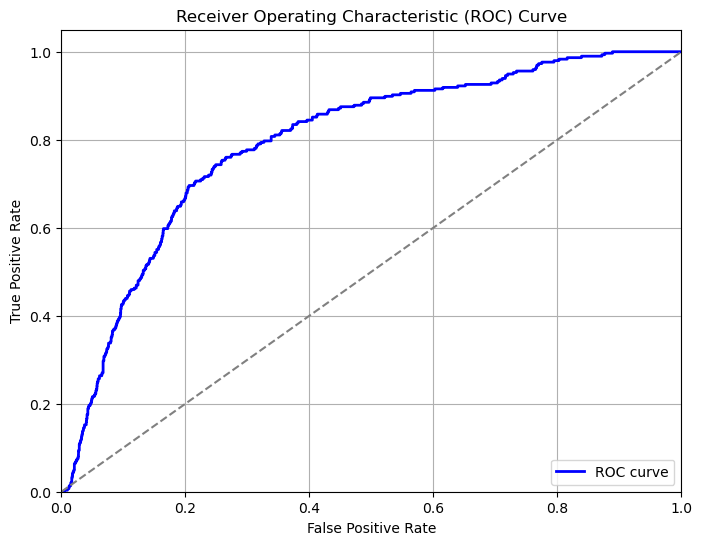

best_threshold=6.789283117919137


In [158]:
# plot ROC
accuracys = np.empty_like(scores)
tprs = np.empty_like(scores)
fprs = np.empty_like(scores)
thresholds = np.sort(scores)

for index,threshold in enumerate(thresholds):
    predicted = scores > threshold
    accuracys[index] = np.sum(predicted == ground_truth)/len(ground_truth)
    tprs[index] = np.sum((predicted == ground_truth)[ground_truth == True])/len(ground_truth[ground_truth == True])
    fprs[index] = 1 - np.sum((predicted == ground_truth)[ground_truth == False])/len(ground_truth[ground_truth == False])
    
def plot_roc_curve(tprs, fprs):
    plt.figure(figsize=(8, 6))
    plt.plot(fprs, tprs, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
plot_roc_curve(tprs, fprs)
metrics  = (1-tprs)**2 + fprs**2
best_threshold = thresholds[np.argmin(metrics)]
print(f"{best_threshold=}")

In [ ]:
# Evaluate on test data
tp,fp,tn,fn = 0,0,0,0
for index, (_, row) in enumerate(test_lf.iterrows()):
    
    label = row['PumpFailed']
    machine_id = row['MachineId']
    measurement_id = row['MeasurementId']
    
    pressure = padf.filter((pc.field('MeasurementId') == measurement_id) & (pc.field('MachineId') == machine_id))['Pressure']
    if len(pressure) == 0:
        print(f"{_,machine_id,measurement_id,label} is empty measurment (all zeros)")
        continue
    try:
        processed_pressure = process_pressure(pressure).to_numpy()
    except ValueError:
        print(f"{_,machine_id,measurement_id,label} is invalid measurment (all zeros)")

    p1 = alternative_hypothesis._calculate_likelihood(processed_pressure)
    p0 = zero_hypothesis._calculate_likelihood(processed_pressure)
    score =  np.log(p1) - np.log(p0)
    prediction = score > best_threshold
    
    if label:
        if prediction:
            tp +=1
        else:
            fn +=1
    else:
        if prediction:
            fp += 1
        else:
            tn += 1        

In [160]:
def print_confusion_matrix(tp, tn, fp, fn):
    print("Confusion Matrix:")
    print("\t\tActual Positive\tActual Negative")
    print(f"Predicted Positive\t{tp}\t\t{fp}")
    print(f"Predicted Negative\t{fn}\t\t{tn}")
    summ = tp + tn + fp + fn
    print(f"All: {summ}")
    print(f"Acc {(tp+tn)/summ:2.2f}")
print_confusion_matrix(tp,tn,fp,fn)


Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	445		1245
Predicted Negative	128		3562
All: 5380
Acc 0.74


### Summarization
190324 2349-0017 28
200324 1819-1907 48 = 76 min
We were able to achive test accuracy of 0.74 with naive bayes Gaussian, since the fault occurence is about 10%, we would be able to achive better accuracy if we were using simple decision -> always non faulty.
There are several ways which could we head, but it is out of the scope of the time requirements.

The code is not optimized and some part of it was created using MLL, It was mostly written on a go. During the training and evaluation, I was able to catch all non working cycles, but was not able to verify, if the bug is in the data (arrays of zeros, unexpected drops / lost of data) or in pipeline. 

The preprocessing is a bit time demanding and would be reasonable to extract the features from the signal and save it. The proposed model is far from ideal, as it is not data agnostic and few decisions were done ad-hoc. More robust model, which would truly correspond to the time series nature were more chalenging and I was not able to code them in time. 

I have exceeded the time dotation roughly, but some time was spend on explenation and description. Some time was also spend for final training/evaluation, which was not active. The total time it took me is about 1.5~1.75 of the normal working day. 